Getting started with Python for Data Science

Meenal Jhajharia

Meenal Jhajharia. she/her. 19.

CS and Math undergrad student

University of Delhi, India

PyMC Core Contributor | GSoC student - PyMC (under NUMFOCUS)

Web - [mjhajharia.com](https://mjhajharia.com )  

You will find this useful if

- You already know an object oriented programming language
- You want to learn Python
- You’re interested in Scientific Computing


Quick facts about Python

- Useful for quick prototyping
- Dynamically Typed
- Interpreted Language
- High level data types
- There’s a large number of scientific open source software in Python

Best Place to learn more : [Official Python documentation](https://docs.python.org/3/tutorial/introduction.html)


Sneak peek into

- Basic Python Syntax
- Numpy and Pandas
- PyMC 

Takeaways

- A taste of reading Python code in large libraries
- This will help you contribute to Open Source + write better code

When browsing code from libraries you aren't familiar with, we'll be focusing on "how" the code works, and be less concerned with the actual use or thought behind it, think of it as, we pick up a random novel to learn how to read or speak, we don't care about the story being told (**only** right now)


If you're on a UNIX system, great, if you're on windows ensure you have a terminal, if not use [this](https://www.microsoft.com/en-in/p/windows-terminal/9n0dx20hk701?rtc=1&activetab=pivot:overviewtab)
```
$ conda install notebook
$ jupyter-notebook
```

Let's get started right away! so for the first half of this session I'll quickly go over basic data cleaning/manipulation in pandas/numpy. Data is one of the most crucial things in any form of scientific analysis, naturally, you cannot make reasonable predictions without meaningful data.

Pandas and Numpy are the most fundamental libraries that you'll be using in Python

To make the process less mundane, I'm going to over the data I had to clean for [a model I made in PyMC for Fantasy Premier League predictions, I gave a talk on this at PyData about two weeks ago!](https://github.com/mjhajharia/pydata21/blob/main/fpl-analysis-model.ipynb)



In [1]:
import pandas as pd
import numpy as np

!curl -o data/2020.csv https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/merged_gw.csv
data20 = pd.read_csv("2020.csv")

!curl -o data/2021.csv https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/merged_gw.csv
data = pd.read_csv("2021.csv")

data20 = pd.read_csv("data/2020.csv")
data = pd.read_csv("data/2021.csv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3494k  100 3494k    0     0  2385k      0  0:00:01  0:00:01 --:--:-- 2383k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3494k  100 3494k    0     0  3643k      0 --:--:-- --:--:-- --:--:-- 3640k


So here's the data elements that we do have, now we don't need all of them

In [2]:
data.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW'],
      dtype='object')

We want to use two years' data so we pick the players that play in both years

In [3]:
players21 = set(data.name)
players20 = set(data20.name)
players20 = players20.intersection(players21)
data20 = data20[data20['name'].isin(players20)]
data = data[data['name'].isin(players20)]

now we want to append the columns `total_points` and `GW` of last year to this year's data. We could join the dataframes directly, but we're not sure if the indexes will match so we do it manually, and fix an index using `data.set_index(cols)`

In [4]:
data20['total_points_20'] = data20['total_points']
data20['GW_20'] = data20['GW']
data20['name_20'] = data20['name']
data20 = data20[['name_20','GW_20','total_points_20']]
cols = ['name','GW']
cols20 = ['name_20','GW_20']
data20.set_index(cols20)
data.set_index(cols)
data = data.join(data20)
data = data[(data['name']==data['name_20']) & (data['GW']==data['GW_20'])]

Map `opponent_team` id's to team_names, we need to do this to inculcate some external data defined in terms of team_names

In [5]:
team_names = sorted(list(set(list((data.team)))))
team_ids = np.arange(1,21)
data['opponent_team'] = data['opponent_team'].map(dict(zip(team_ids, team_names)))

External data of last year

In [6]:
#in previous year
goals_conceded_by_team = {'Arsenal': 39,'Aston Villa': 46,'Brighton': 46,'Burnley': 55,
                          'Chelsea': 36,'Crystal Palace': 66,'Everton': 48,'Fulham': 55,
                          'Leeds': 54,'Leicester': 50,'Liverpool': 42,'Man City': 32,
                          'Man Utd': 44,'Newcastle': 62,'Sheffield Utd': 63,'Southampton': 68,
                          'Spurs': 45,'West Brom': 76,'West Ham': 47,'Wolves': 52}

goals_scored= {'Man City':83,'Man Utd':73,'Leicester':68,
               'Liverpool':68,'Spurs':68,'Leeds':62,'West Ham':62,
               'Chelsea':58,'Arsenal':55,'Aston Villa':55,'Southampton':48,
               'Everton':47,'Newcastle':46,'Brighton':41,'Crystal Palace':41,
               'Wolves':36,'West Brom':35,'Burnley':33,'Fulham':27,'Sheffield Utd':20}

team_wins = {'Man City': 27,'Man Utd': 21, 'Leicester': 20,'Liverpool': 20,
             'Chelsea': 19,'West Ham': 19,'Arsenal': 18,'Leeds': 18,'Spurs': 18,
             'Everton': 17,'Aston Villa': 16,'Crystal Palace': 12,'Newcastle': 12,
             'Southampton': 12,'Wolves': 12,'Burnley': 10,'Brighton': 9,
             'Sheffield Utd': 7,'Fulham': 5,'West Brom': 5}

Create columns for this new information by mapping with `team_name`, additionally rank these points as `1`, `2`, `3` or `4` this is better than absolute ranks because it clusters teams together and reduces computational load on our final model

In [7]:
#we measure goals_conceded as an inverse indicator of defense strength
data['opp_defense_rank'] = data['opponent_team'].map(goals_conceded_by_team)
data.sort_values(by =['opp_defense_rank'], inplace = True)
data['opp_defense_rank']= pd.qcut(data['opp_defense_rank'],q = 4, labels = False)

#Goals scored are an attribute of team strength
data['opp_attack_rank'] = data['opponent_team'].map(goals_scored)
data.sort_values(by =['opp_attack_rank'], inplace = True)
data['opp_attack_rank']= pd.qcut(data['opp_attack_rank'],q = 4, labels = False)

#Final rankings naturally give an idea of the overall team strength/quality

data['team_cluster_rank'] = data['opponent_team'].map(goals_scored)
data.sort_values(by =['team_cluster_rank'], inplace = True)
data['team_cluster_rank']= pd.qcut(data['team_cluster_rank'],q = 4, labels = False)                                                                     

data['opp_cluster_rank'] = data['opponent_team'].map(goals_scored)
data.sort_values(by =['opp_cluster_rank'], inplace = True)
data['opp_cluster_rank']= pd.qcut(data['opp_cluster_rank'],q = 4, labels = False)

We map the names back to integers

In [8]:
data['opponent_team'] = data['opponent_team'].map(dict(zip(team_names, team_ids)))
data['team'] = data['team'].map(dict(zip(team_names, team_ids)))

We store the initial valuation of each player as a metric for prediction

In [9]:
initval = data[data['GW']==1][["name","value"]]
data['initval'] = data['name'].map(dict(zip(initval.name, initval.value)))

One hot encode the positions

In [10]:
data['pos_id'] = data['position']
data = pd.get_dummies(data,columns=['position'])
pos_ids = np.array([k for k in data['pos_id'].unique()])
data['pos_id']=data['pos_id'].apply(lambda x : np.where(x == pos_ids)[0][0])

Average (expected) scores of players' last year data

In [11]:
data['game_avg_7']= data.groupby(['name']
                                )['total_points_20'].rolling(7).mean().reset_index(0,drop=True)

data.sort_values(by =['game_avg_7'], inplace = True)
data['rank']= pd.qcut(data['game_avg_7'],q = 4, labels = False)
data['diff_from_avg'] = data['total_points'] - data['game_avg_7']

Eliminate very low scoring players to avoid skewing data

In [12]:
pts=data.groupby(['name']).sum()
pts = pts[pts['total_points']>50]
chosen_players = pts.index
data = data[data['name'].isin(chosen_players)]

One hot encode `was_home` and retain the original column as well

In [13]:
data['was_homee']=data['was_home']
data = pd.get_dummies(data,columns=['was_home'])
data['was_home']=data['was_homee']
data = data.dropna()

Select useful columns and store final data

In [14]:
data = data[['name', 'total_points','position_DEF','GW','team',
             'opponent_team','position_FWD', 'position_GK', 
             'position_MID', 'game_avg_7' ,'pos_id',
             'initval','rank','diff_from_avg',
            'opp_defense_rank','opp_attack_rank','team_cluster_rank',
            'opp_cluster_rank','was_home','total_points_20']]
data.sort_values(by=['GW'],inplace=True)
data.to_csv('data/data.csv',index=False)

Now we're going to go into the second half of this tutorial, where we try to understand how python open source packages work. Let's try to break-down a very simple distribution in PyMC. - Yes it's Normal

These are the relevant files - [distribution.py](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/distribution.py) and [continuous.py](https://github.com/pymc-devs/pymc/blob/31b4a37076668a9a12ef856852e563ae8faf02f2/pymc/distributions/continuous.py#L243)

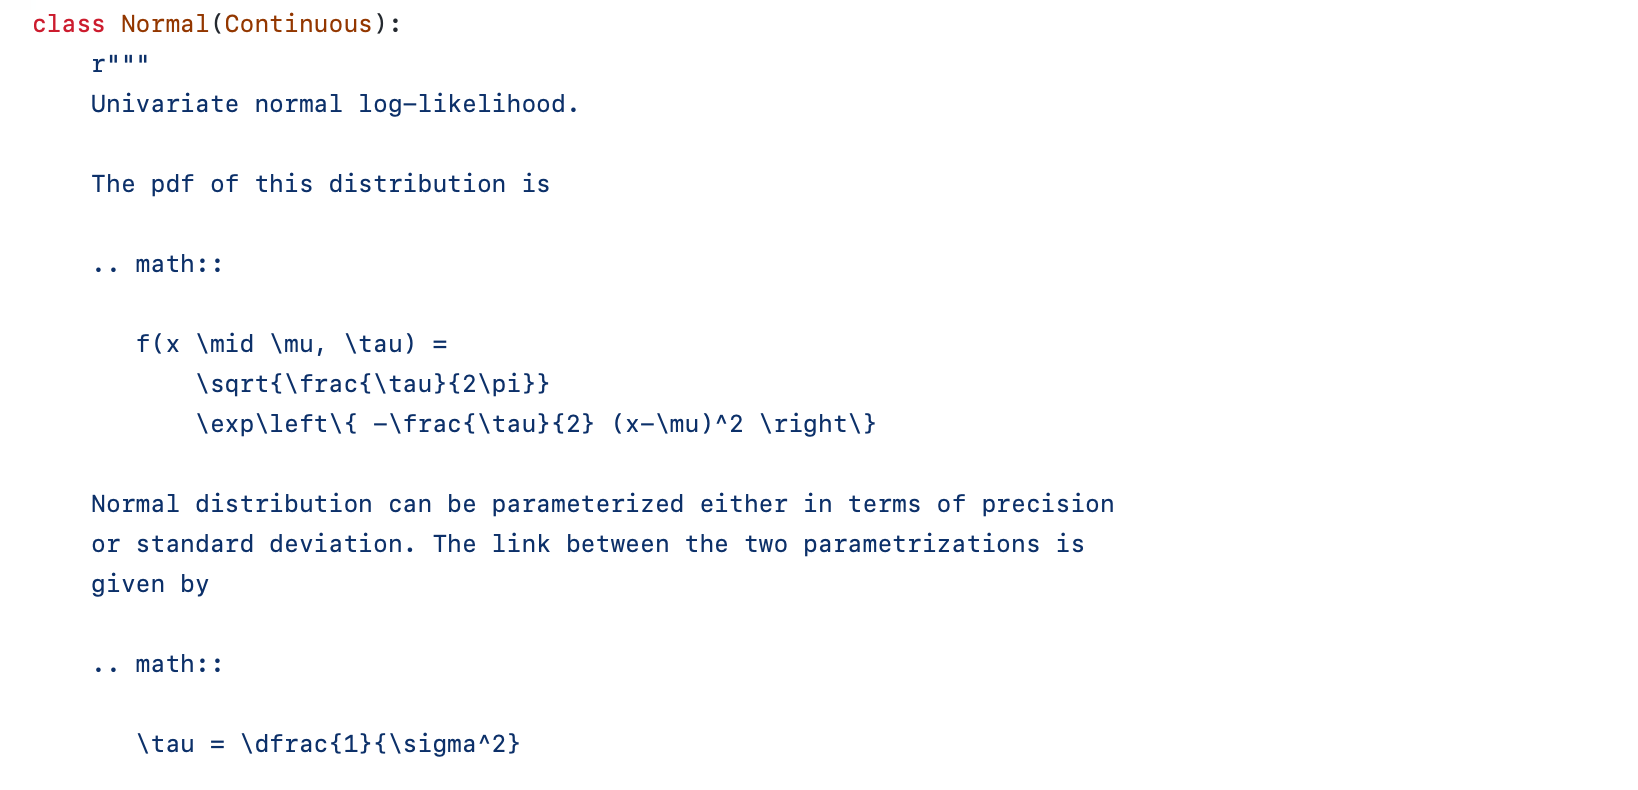

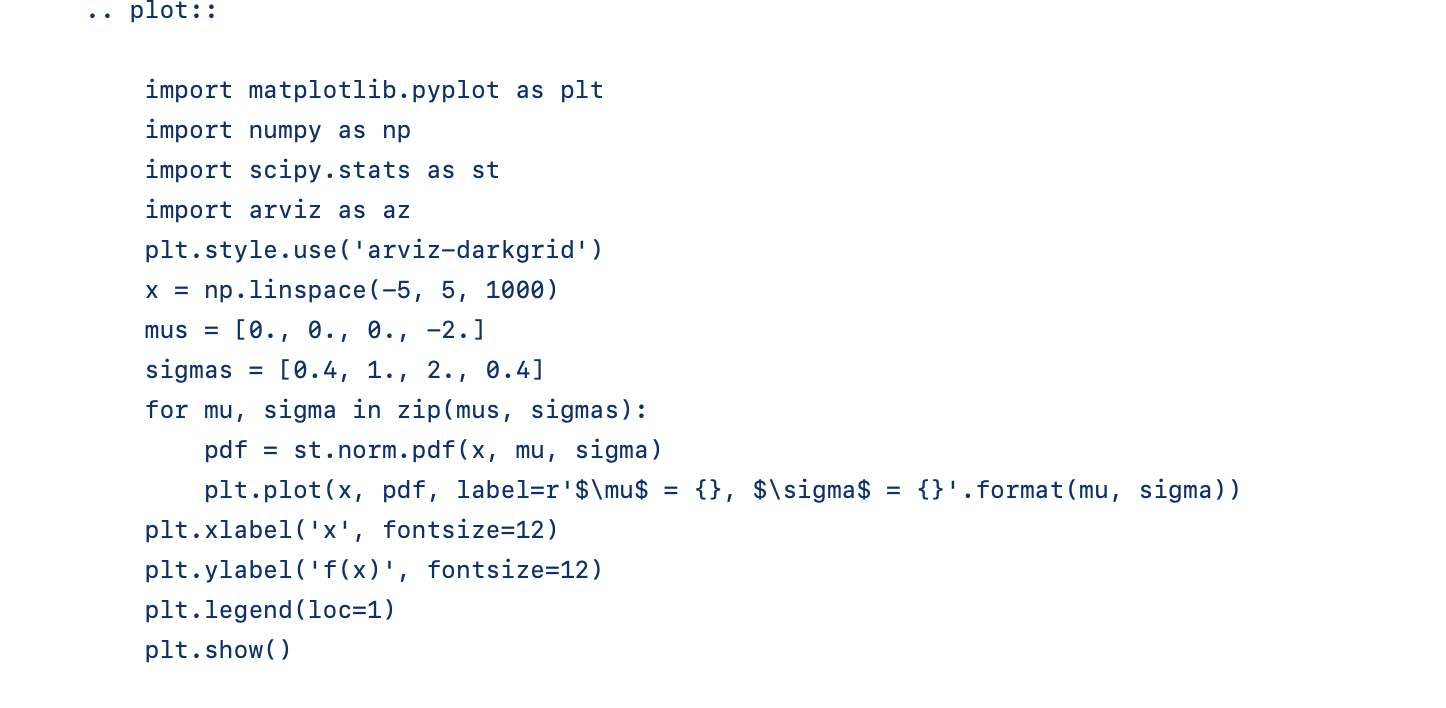

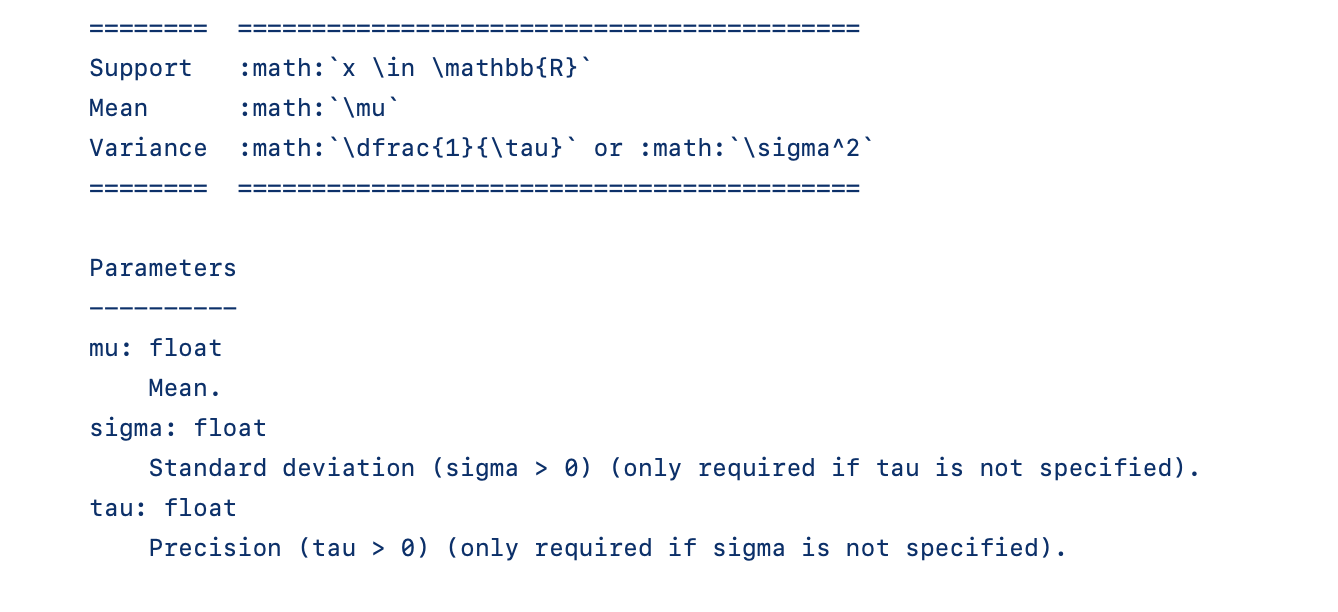

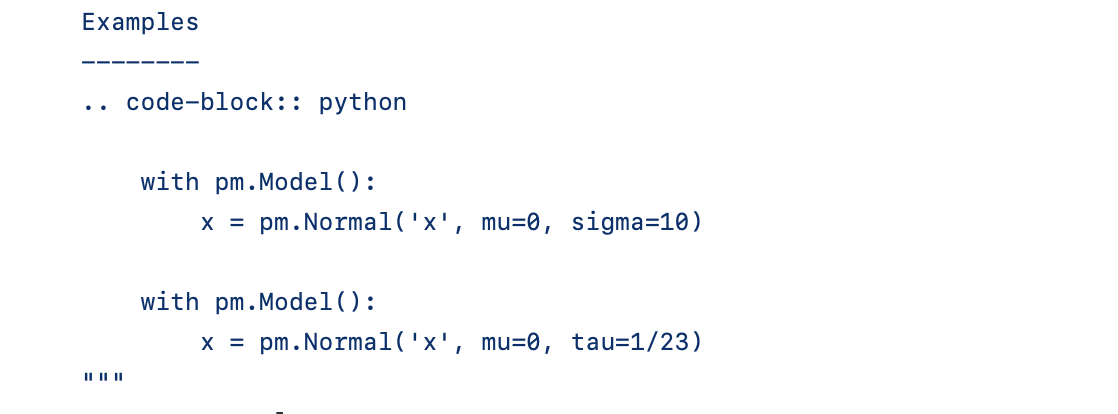

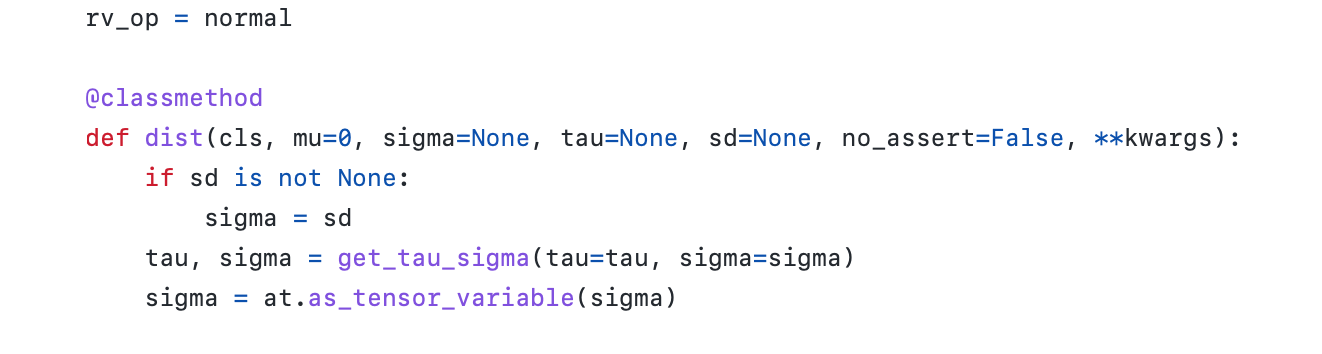

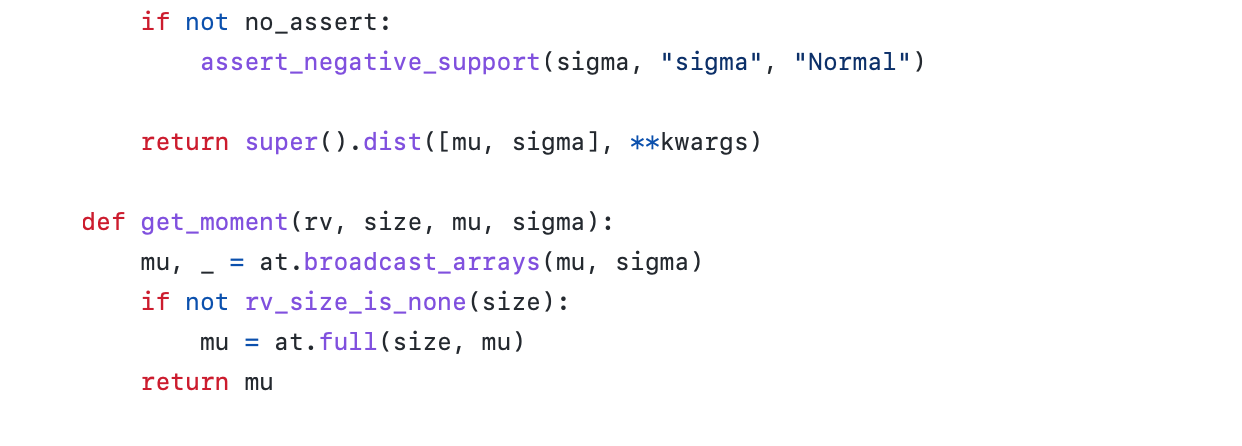

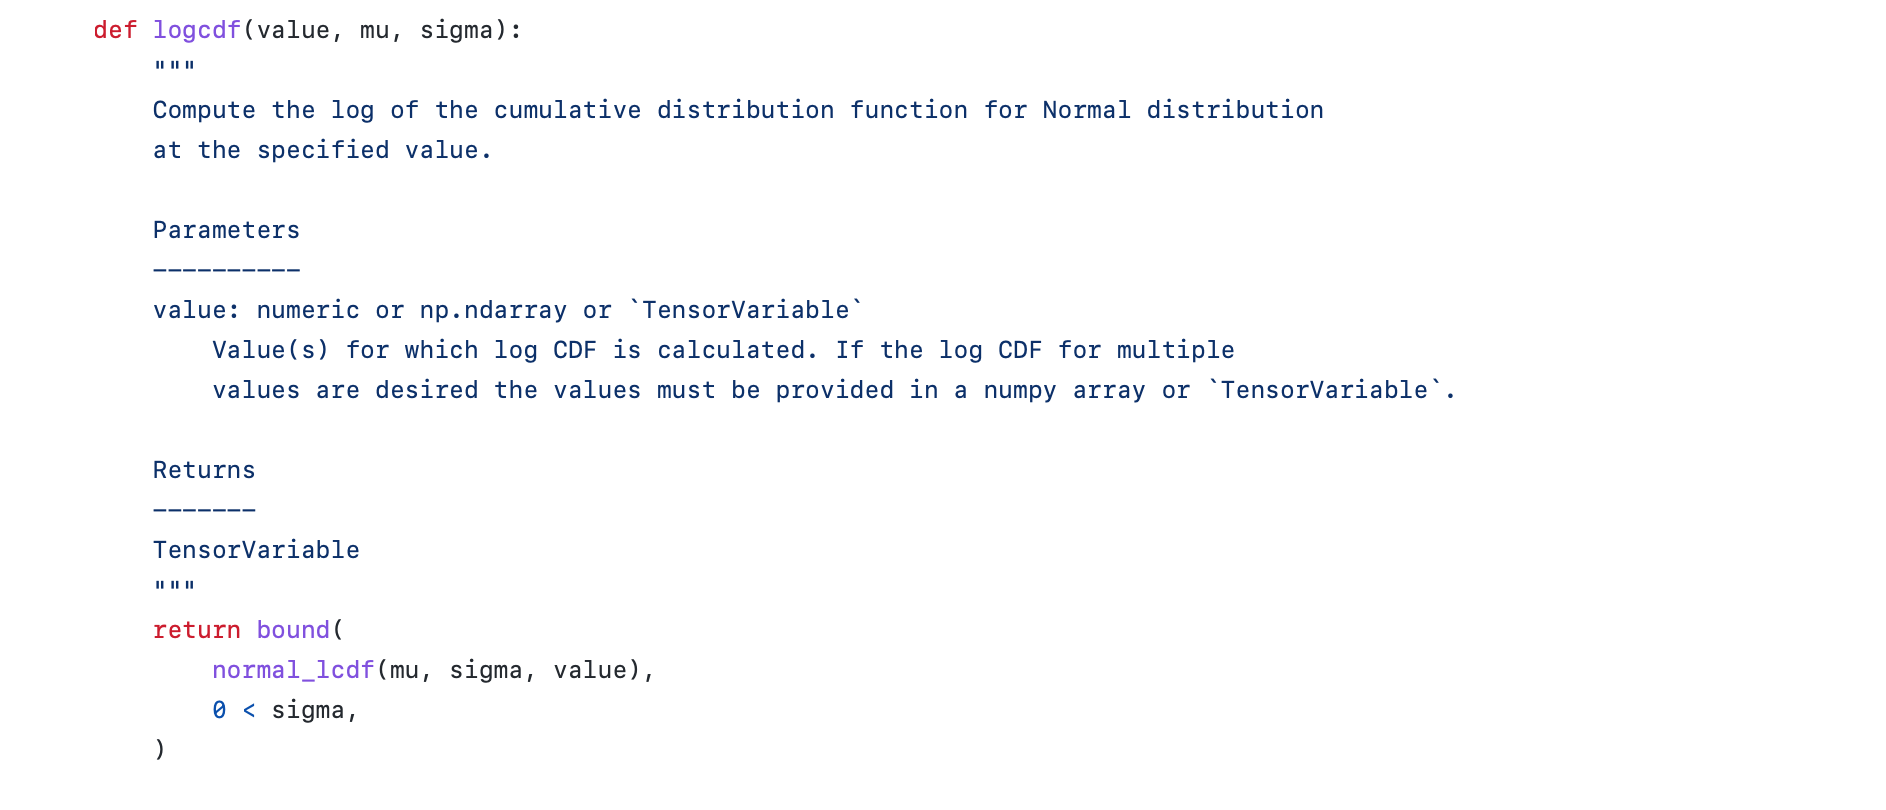